# Gold and USD inflation
Using monthly data we will explore the relationship between gold prices and
inflation.

### Inspirations
- [The FRED® Blog: Is gold a good hedge against inflation?]
(https://fredblog.stlouisfed.org/2019/03/is-gold-a-good-hedge-against-inflation/)

### Definitions
- Gold: The ICE Benchmark Administration Limited (IBA), Gold Fixing Price in
the London Bullion Market, based in U.S. Dollars, retrieved from FRED,
Federal Reserve Bank of St. Louis
- CPI inflation: Consumer Price Index, seasonally adjusted monthly since 1947,
, retrieved from FRED, Federal Reserve Bank of St. Louis
- PCE inflation: Personal Consumption Expenditure, seasonally adjusted monthly
since 1959, retrieved from FRED, Federal Reserve Bank of St. Louis
- SYN inflation: Synthetic Inflation, normalized and averaged over CPI,
CPI Core, PCE and PCE Core inflation measures, retrieved from FRED, Federal
Reserve Bank of St. Louis

### Dependencies:
- Python: datetime, fecon236, matplotlib, numpy, pandas, pandas_datareader,
sklearn, statsmodels, sympy, seaborn
- Written using Python 3.8.5, Atom 1.51, Hydrogen 2.14.4


## 0. Preamble / Code Setup

### A. Check if required modules are installed in the kernel; and if not install them

In [1]:
import sys
import subprocess
import pkg_resources
required = {'datetime', 'fecon236', 'matplotlib', 'numpy', 'pandas',
            'pandas_datareader', 'sklearn', 'statsmodels', 'sympy', 'seaborn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                           stdout=subprocess.DEVNULL)

In [2]:
# fecon236 is a useful econometrics python module for access and using U.S.
# Federal Reserve and related data
import fecon236 as fe
fe.system.specs()
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2   # Use 0 to disable this feature.

 !:  Code for this project straddles python27 and python3.
 ::  Python 3.8.5
 ::  IPython 7.18.1
 ::  jupyter_core 4.6.3
 ::  jupyter_client 6.1.7
 ::  notebook 6.1.4
 ::  matplotlib 3.3.1
 ::  numpy 1.19.2
 ::  scipy 1.5.2
 ::  statsmodels 0.12.0
 ::  sympy 1.6.2
 ::  pandas 1.1.2
 ::  pandas_datareader 0.9.0
 ::  fecon236 10.8.0
 ::  Repository: git_repo_None tag_None branch_None
 ::  Timestamp: 2020-09-18T10:56:22Z


### B. Import useful modules for data wrangling

In [3]:
import numpy as np
import math
import datetime as dt

### C. Will use sklearn and statsmodels for model development and testing

In [4]:
from sklearn import mixture
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import MeanShift, estimate_bandwidth, MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
# from sklearn.datasets import make_blobs
import statsmodels.api as sm

### D. Notebook dispaly and formatting options

In [5]:
# Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option('display.notebook_repr_html', False)
# Alter Jupyter option for the pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Import matplotlib and seaborn for plotting
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm   ### CAN WE GET RID OF THIS WITH SEABORN
#  Generate plots inside notebook, "inline" generates static png
%matplotlib inline
# Use seaborn for to make matplotlib pretty and set the default theme styles
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

## 1. Define Custom Functions
### A. Custom Plotting Function to Make Charts *Pretty*

In [6]:
def sns_plotfn(data: pd.core.frame.DataFrame, degree: int=1, title: str=''):
    """Draws plot from data input and defined fit function

    Parameters
    ----------
    data : panda DataFrame
        Panda data frame containing the data, m rows by 2 columns with the
        first column containing the indepedent variable (i.e. x) and the second
        column containing the dependent variable (i.e. y)
    poly1d_fun : numpy poly1d
        the polynomial definition e.g. x**2 + 2*x + 3
    title : str, optional
        title to include on the chart

    Returns
    -------
    Null
    """
    xnm = list(data.columns)[0]
    ynm = list(data.columns)[1]
    snsplt = sns.lmplot(x=xnm, y=ynm, data=data, order=degree, aspect=1.333,
                        palette="muted")
    snsplt.despine(left=True)
    return

### B. Function to Define Polynomial Model

In [7]:
def defnmodel(data: pd.core.frame.DataFrame, degree: int=1):
    """Defines a polynomial model for data x and y of order degree using
    ordinary least squares regression based

    Parameters
    ----------
    data : panda DataFrame
        Panda data frame containing the data, m rows by 2 columns with the
        first column containing the indepedent variable (i.e. x) and the second
        column containing the dependent variable (i.e. y)
    degree : int, optional
        the polynomial degree definition e.g. 2 for a quadractic polynomial

    Returns
    -------
    xp : numpy array
        array of degree columns containing the polynomial features e.g. for a 2
        degree polynomial, features are [1, a, b, a^2, ab, b^2]
    model : sm ols model
        orindary least squares regression model produced by statsmodels
    poly1d_fn : numpy poly1d
        the polynomial definition e.g. x**2 + 2*x + 3
    """
    polyFeatures = PolynomialFeatures(degree) # Define the polynomial

    # Reshape data from 1 by n to n by 1
    xarray = np.array(data.iloc[:, 0])
    xarray = xarray[:, np.newaxis]

    # Calculate polynomials for x
    xp = polyFeatures.fit_transform(xarray)

    # Reshape y from 1 by n to n by 1
    yarray = np.array(data.iloc[:, 1])
    yarray = yarray[:, np.newaxis]

    # Calculate the model and predictions
    model = sm.OLS(yarray, xp).fit()
    coef = model.params.tolist()    # Model coefficients
    coef.reverse()                  # Reverse as poly1d takes in decline order
    poly1d_fn = np.poly1d(coef)     # Create function from coefficients

    return xp, model, poly1d_fn

### C. Roll-up Function to Display Results

In [8]:
def displayresults(data: pd.core.frame.DataFrame, degree: int=1, title: str=''):
    """Displays summary statistics, regression results, and plot of data
    versus polynomial model

    Parameters
    ----------
    data : panda DataFrame
        Panda data frame containing the data, m rows by 2 columns with the
        first column containing the indepedent variable (i.e. x) and the second
        column containing the dependent variable (i.e. y)
    degree : int, optional
        the polynomial degree definition e.g. 2 for a quadractic polynomial
    title : str, optional
        title to include on the chart

    Returns
    -------
    Null
    """
    xp, model, poly1d_fn = defnmodel(data, degree)
    print(" ::  FIRST variable (y):")
    print(data.iloc[:, 1].describe(), '\n')
    print(" ::  SECOND variable (x):")
    print(data.iloc[:, 0].describe(), '\n')
    print(model.summary())
    sns_plotfn(data, degree, title)
    return

## 2. Retrieve Data, Determine Appropiate Start and End Dates for Analysis

In [9]:
# Get gold and inflation rates, both as monthly frequency
# Notes: fecon236 uses median to resample (instead of say mean) and also
# replaces FRED empty data (marked with a ".") with data from previously
# occuring period; These adjustments will drive some small differences to
# the analysis on th FRED blog
# Daily London AM gold fix, nominal USD, converted to monthly
gold_usdnom = fe.monthly(fe.get('GOLDAMGBD228NLBM'))
# Daily London PM gold fix, nominal USD, converted to monthly
# gold_usdnom = fe.get(fe.m4xau)
# Percentage calcualtion for month on month i.e. frequency = 1
freq = 1
gold_usdnom_pc = fe.nona(fe.pcent(gold_usdnom, freq))

In [10]:
# Inflation in use
infcode = fe.m4cpi      # FRED code 'CPIAUCSL'
# infcode = fe.m4pce    # FRED code 'PCEPI'
# Synthetic average of 'CPIAUCSL', 'CPILFESL', 'PCEPI', 'CPILFESL'
# infcode = fe.m4infl
infidx = fe.get (fe.m4cpi)        # Returns the index, not percentage change
inf_pc = fe.nona(fe.pcent(infidx, freq))

In [11]:
# Gold with USD inflation removed i.e. in real USD
# First, calculate rebased inflation index
inf_basedate = '2020-08-01'              # The base date for our index
inf_base = infidx['Y'][inf_basedate]
infidx_rebased = fe.div(infidx, inf_base)

In [12]:
# Find the first and last overlapping dates for the two data series where
# we are using values
startv = max(fe.head(gold_usdnom, 1).index[0], fe.head(infidx, 1).index[0])
endv = min(fe.tail(gold_usdnom, 1).index[0], fe.tail(infidx, 1).index[0])

In [13]:
# Calculate the real gold price
gold_usdrl = fe.div(gold_usdnom.loc[startv:endv],
                    infidx_rebased.loc[startv:endv])
gold_usdrl_pc = fe.nona(fe.pcent(gold_usdrl, freq))

In [14]:
# Find the first and last overlapping dates for the two data series where we
# are using month on month percentage change
startpc = max(fe.head(gold_usdrl_pc, 1).index[0], fe.head(inf_pc, 1).index[0])
endpc = min(fe.tail(gold_usdrl_pc, 1).index[0], fe.tail(inf_pc, 1).index[0])

## 3. Look at the Correlation of Month on Month Change in Inflation and Nominal Gold Prices

 ::  FIRST variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nominal USD), dtype: float64 

 ::  SECOND variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     15.18
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           0.000108
Time:                        06:56:24   Log-Likelihood:                -1898.5
No. Observations:                 628   AIC:  

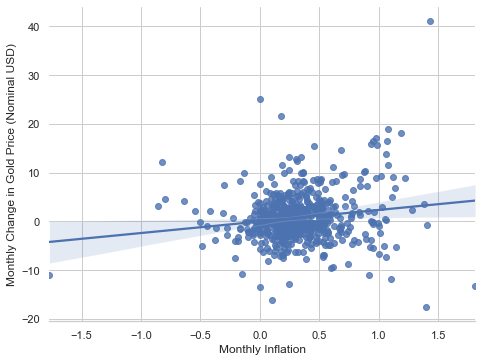

In [15]:
mom_npc = pd.concat([inf_pc[startpc:endpc], gold_usdnom_pc[startpc:endpc]], axis=1)
mom_npc.columns = ['Monthly Inflation', 'Monthly Change in Gold Price (Nominal USD)']
data = mom_npc
title = 'MoM Change in Nominal Gold Price vs Inflation {} to {}'
title = title.format(startpc.strftime("%b %Y"), endpc.strftime("%b %Y"))
displayresults(data, 1, title)

2020-09-15: The regression analysis shows a strong relationship
(t-stat 3.896), however we need to remove the inflation contained in the
nominal gold price

## 4. Look at the Correlation of Month on Month Change in Inflation and Real Gold Prices

 ::  FIRST variable (y):
count    628.000000
mean       0.424768
std        4.969401
min      -18.682068
25%       -2.101499
50%       -0.149381
75%        2.375664
max       39.130120
Name: Monthly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.038
Date:                Fri, 18 Sep 2020   Prob (F-statistic):             0.0251
Time:                        06:56:24   Log-Likelihood:                -1894.9
No. Observations:                 628   AIC:     

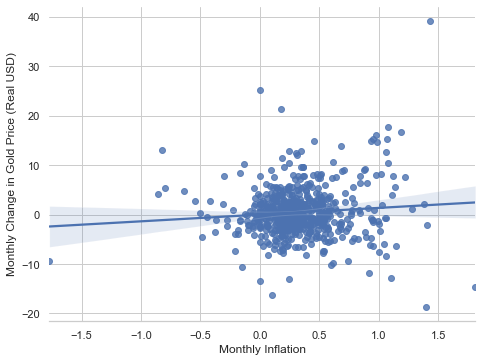

In [16]:
mom_rpc = pd.concat([inf_pc[startpc:endpc], gold_usdrl_pc[startpc:endpc]], axis=1)
mom_rpc.columns = ['Monthly Inflation', 'Monthly Change in Gold Price (Real USD)']
data = mom_rpc
title = 'MoM Change in Real Gold Price vs Inflation {} to {}'
title = title.format(startpc.strftime("%b %Y"), endpc.strftime("%b %Y"))
displayresults(data, 1, title)

2020-09-15: The regression analysis shows a relationship
(t-stat 2.245), with a 1% increase in inflation having a 1.3573% increase in
the real price of gold. However, the adj. r-squared is only 0.006, indicating
there are many other factors at play that influence the change in gold prices.

## 5. Look at the Correlation of Year on Year Change in Inflation and Real Gold Prices

In [17]:
# Change percentage calcualtion to every 12 months
freq = 12
gold_usdrl_apc = fe.nona(fe.pcent(gold_usdrl, freq))
inf_apc = fe.nona(fe.pcent(infidx, freq))

In [18]:
# Find the first and last overlapping dates for the two data series
startapc = max(fe.head(gold_usdrl_apc, 1).index[0], fe.head(inf_apc, 1).index[0])
endapc = min(fe.tail(gold_usdrl_apc, 1).index[0], fe.tail(inf_apc, 1).index[0])

 ::  FIRST variable (y):
count    617.000000
mean       5.791374
std       24.127117
min      -42.941169
25%       -9.224234
50%        2.027081
75%       17.016432
max      151.801206
Name: Yearly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    617.000000
mean       3.988334
std        2.937670
min       -1.958761
25%        2.085967
50%        3.167668
75%        4.940924
max       14.592275
Name: Yearly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     65.92
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           2.57e-15
Time:                        06:56:25   Log-Likelihood:                -2807.7
No. Observations:                 617   AIC:       

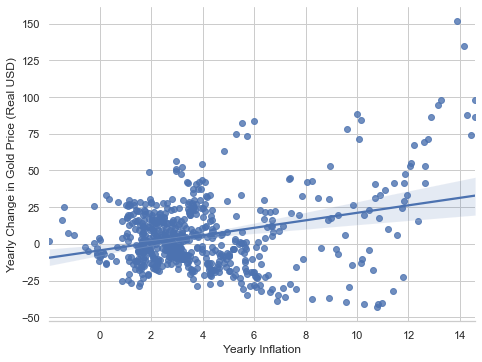

In [19]:
# Show same analysis as above
yoy_rpc = pd.concat([inf_apc[startapc:endapc],
                     gold_usdrl_apc[startapc:endapc]], axis=1)
yoy_rpc.columns = ['Yearly Inflation', 'Yearly Change in Gold Price (Real USD)']
data = yoy_rpc
title = 'YoY Change in Real Gold Price vs Inflation {} to {}'
title = title.format(startapc.strftime("%b %Y"), endapc.strftime("%b %Y"))
displayresults(data, 1, title)

2020-09-15: The regression analysis shows a relationship
(t-stat 8.119), with a 1% increase in inflation having a 2.5554% increase in
the real price of gold; the adj. r-squared has increased slightly to 0.095, so
still many other factors at play in determing the gold price

Another way to consider this is, yes gold may hedge inflation, but with so
many other (so far unknown) factors impacting the price of gold, there is lot
of risk in using gold to purely hedge inflation

Potentially there is greater movement in the gold price when the inflation
change is > ~8%

## 6. Alternative Models for Year on Year Change in Inflation and Real prices
### A. First, lets explore a polynomial model

 ::  FIRST variable (y):
count    617.000000
mean       5.791374
std       24.127117
min      -42.941169
25%       -9.224234
50%        2.027081
75%       17.016432
max      151.801206
Name: Yearly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    617.000000
mean       3.988334
std        2.937670
min       -1.958761
25%        2.085967
50%        3.167668
75%        4.940924
max       14.592275
Name: Yearly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     84.11
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           5.21e-33
Time:                        06:56:25   Log-Likelihood:                -2764.4
No. Observations:                 617   AIC:       

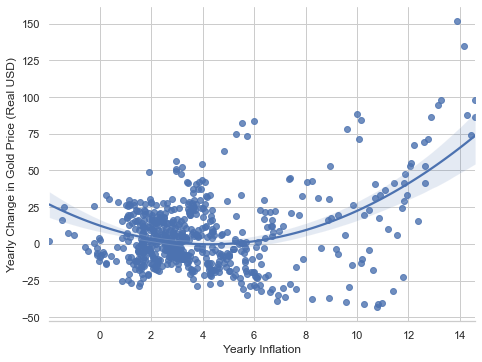

In [20]:
displayresults(data, 2, title)

2020-09-15: For `degree = 2` We show a stronger relationship (higher t-stats
and adj. r-squared of 0.212), however it is not clear why a quadractic
equation is an appropiate relationship between inflation and gold prices

 ::  FIRST variable (y):
count    617.000000
mean       5.791374
std       24.127117
min      -42.941169
25%       -9.224234
50%        2.027081
75%       17.016432
max      151.801206
Name: Yearly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    617.000000
mean       3.988334
std        2.937670
min       -1.958761
25%        2.085967
50%        3.167668
75%        4.940924
max       14.592275
Name: Yearly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     76.62
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           4.27e-42
Time:                        06:56:25   Log-Likelihood:                -2740.9
No. Observations:                 617   AIC:       

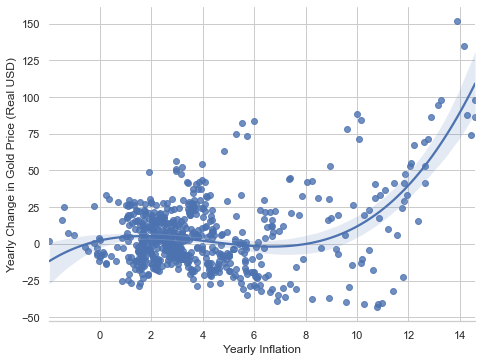

In [21]:
displayresults(data, 3, title)

2020-09-15: For `degree = 3`, relationship is weaker and not interesting

 ::  FIRST variable (y):
count    617.000000
mean       5.791374
std       24.127117
min      -42.941169
25%       -9.224234
50%        2.027081
75%       17.016432
max      151.801206
Name: Yearly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    617.000000
mean       3.988334
std        2.937670
min       -1.958761
25%        2.085967
50%        3.167668
75%        4.940924
max       14.592275
Name: Yearly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     58.61
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           6.84e-42
Time:                        06:56:26   Log-Likelihood:                -2739.1
No. Observations:                 617   AIC:       

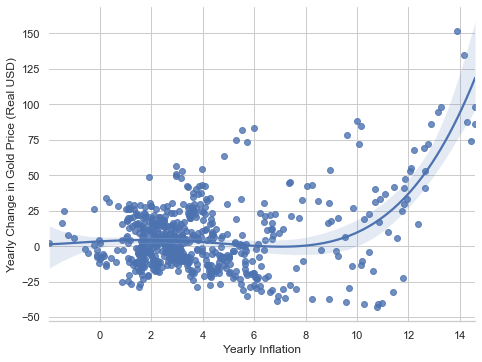

In [22]:
displayresults(data, 4, title)

2020-09-15: For `degree = 4`, relationship is even weaker and not interesting

 ::  FIRST variable (y):
count    617.000000
mean       5.791374
std       24.127117
min      -42.941169
25%       -9.224234
50%        2.027081
75%       17.016432
max      151.801206
Name: Yearly Change in Gold Price (Real USD), dtype: float64 

 ::  SECOND variable (x):
count    617.000000
mean       3.988334
std        2.937670
min       -1.958761
25%        2.085967
50%        3.167668
75%        4.940924
max       14.592275
Name: Yearly Inflation, dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     47.43
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           1.87e-41
Time:                        06:56:26   Log-Likelihood:                -2737.9
No. Observations:                 617   AIC:       

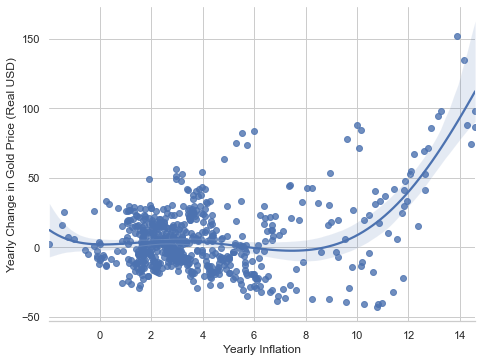

In [23]:
displayresults(data, 5, title)

2020-09-15: For `degree = 5`, now relationships are unidentifiable

### B. Will now consider clustering analysis to see if there is a relationship at higher inflation changes

### C. First, see the result of using k-means

In [24]:
# Create NumPy array to hold data
apc_npa = np.column_stack((inf_apc['Y'][startapc:endapc], gold_usdrl_apc['Y'][startapc:endapc]))

In [25]:
# Compute the clustering with k-means
n_clusters = 4
apc_kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(apc_npa)
k_means_cluster_centers = apc_kmeans.cluster_centers_
k_means_labels = pairwise_distances_argmin(apc_npa, k_means_cluster_centers)

In [26]:
# Plot the results
colors = tableau20
plt.figure(figsize=(12, 9))
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(apc_npa[my_members, 0], apc_npa[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

NameError: name 'tableau20' is not defined

2020-09-15: For `n_clusters = 2`, k-means splits the data essentially along
horizontal axis, seperating when the gold price change into two halves of
when it is positive vs. negative. For `n_clusters = 3`, the data is further
disected along a horizontal line for gold change at approx 50%. A similar
trend occurs for `n_clusters = 4` with a furhter horizontal bisection. In
summary, it is not obvious that horizontal clustering provides any insight
into the gold vs. inflation relationship

### D. Second, see the result of using Expectation-Maximization (EM) implemented using Gaussian Mixture Model (GMM)

In [ ]:
# fit a GMM
n_components = 3
gmmmdl = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
gmmmdl.fit(apc_npa)

# display predicted scores by the model as a contour plot
xln = np.linspace(math.floor(min(apc_npa[:, 0])), math.ceil(max(apc_npa[:, 0])))
yln = np.linspace(math.floor(min(apc_npa[:, 1])), math.ceil(max(apc_npa[:, 1])))
Xln, Yln = np.meshgrid(xln, yln)
XX = np.array([Xln.ravel(), Yln.ravel()]).T
Zln = -gmmmdl.score_samples(XX)
Zln = Zln.reshape(Xln.shape)


In [ ]:
# Create and dsiplay the plot
fig = plt.figure(figsize=(12, 9))
CS = plt.contour(Xln, Yln, Zln, norm=LogNorm(vmin=1, vmax=100.0),
                 levels=np.logspace(0, 2, 25));
CB = plt.colorbar(CS, shrink=0.8);
plt.scatter(apc_npa[:, 0], apc_npa[:, 1], .8);
plt.show()


2020-09-15: For `n_components = 2`, GMM essentially places a high likliehood
around the cluster of data centered on [3, 0] and doesn't pay much attention
to the rest. Not until `n_components ~ 10` does GMM lend any importance to
the data points in the upper left i.e. where this is a high change in
inflation and gold prices

### E. Third, have a look at the OPTICS clustering algorithm

In [ ]:
# Define fit parameters
clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
# Run the fit
clust.fit(apc_npa)
eps = 2.0
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=eps)

In [ ]:
# Create and dsiplay the plot using OPTICS
fit = plt.figure(figsize=(12, 9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for klass, color in zip(range(0, 5), colors):
    apc_npak = apc_npa[clust.labels_ == klass]
    ax1.plot(apc_npak[:, 0], apc_npak[:, 1], color=color, marker='o',
             ls='', alpha=0.3);

ax1.plot(apc_npa[clust.labels_ == -1, 0],
         apc_npa[clust.labels_ == -1, 1], 'k+', alpha=0.1);
ax1.set_title('Automatic Clustering: OPTICS')
# plt.show()
# DBSCAN at eps=2.
for klass, color in zip(range(0, 4), colors):
    apc_npak = apc_npa[labels_200 == klass]
    ax2.plot(apc_npak[:, 0], apc_npak[:, 1], color=color, marker='o',
             ls='', alpha=0.3)
ax2.plot(apc_npa[labels_200 == -1, 0], apc_npa[labels_200 == -1, 1],
         'k+', alpha=0.1);
title = 'Clustering at {0:.2f} epsilon cut: DBSCAN'.format(eps)
ax2.set_title(title)
plt.show()

2020-09-15: So similar to previous methods, clustering appears as horizontal
bisections

### F. Lastly, lets look at using Mean-Shift (MS)

In [ ]:
# Calculate the MS
bandwidth = estimate_bandwidth(apc_npa, quantile=0.25)
apc_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
apc_ms.fit(apc_npa)
labels = apc_ms.labels_
cluster_centers = apc_ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
# Plot result
fig = plt.figure(figsize=(12, 9));
for k, color in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(apc_npa[my_members, 0], apc_npa[my_members, 1], color=color,
             marker='o', ls='', alpha=0.3)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

2020-09-15: And so the same story continues, clustering appears as horizontal
bisections

### End Of File